In [71]:
# Import packages for later use
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [62]:
# define johnson transformation
def johnson(y):
    gamma, eta, epsilon, lbda = st.johnsonsu.fit(y)
    yt = gamma + eta * np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

# Get the data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data['Training'] = 1
test_data['Training'] = 0
numerical_features = train_data.dtypes[train_data.dtypes != 'object'].index.values
categorical_features = train_data.dtypes[train_data.dtypes == 'object'].index.values
omit = ['SalePrice', 'Id', 'Training']
submit = ['SalePrice', 'Id']
significant_columns_cat = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish',
 'FireplaceQu', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC',
 'MasVnrType', 'BsmtExposure', 'SaleCondition', 'Exterior1st', 'Exterior2nd']
significant_columns_cont = ['OverallQual',
    'YearBuilt',
    'YearRemodAdd',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'FullBath',
    'TotRmsAbvGrd',
    'GarageYrBlt',
    'GarageCars']
significant_columns = [*significant_columns_cat, *numerical_features]
# preprocess

# drop one row in training
train_data.dropna(subset=['Electrical'], inplace=True)

# concat
all_data = pd.concat([train_data, test_data], ignore_index=True)

# fill categoricals
categoricals = all_data[categorical_features]
categoricals.fillna('None', inplace=True)
all_data[categorical_features] = categoricals

# fill numericals with 0
all_data.fillna(0, inplace=True)

# select significant columns
all_data = all_data[significant_columns]

# process categoricals
all_data = pd.get_dummies(data=all_data)

train_set = all_data.loc[all_data['Training'] == 1]
test_set = all_data.loc[all_data['Training'] == 0]

# obtain X & y
y = train_set['SalePrice']
y_log = np.log1p(y)
y_j, gamma, eta, epsilon, lbda = johnson(y)

X = train_set[[c for c in train_set.columns if c not in omit]]
X_test = test_set[[c for c in test_set.columns if c not in omit]]


In [77]:
# create lasso model for log transformed data
alphas = np.arange(1e-5, 1e-3, 2e-6)
reg = LassoCV(cv=5, random_state=0, max_iter=50000, alphas=alphas, n_alphas=len(alphas), eps=1e-2).fit(X, y_log)


In [56]:
# create xgboost cv parameter tuning
# First grid to search depth and n_estimators
xgb_model = XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model,
    {'max_depth': [3, 4, 5],
    'n_estimators': [100, 500, 1000, 5000]
    }, verbose=1, n_jobs=1)
clf.fit(X, y_log)

best_depth = 3
best_estimator = 500

# second grid for learning rate and gamma
xgb_model = XGBRegressor(n_jobs=1, max_depth=best_depth, n_estimators=best_estimator)
clf = GridSearchCV(xgb_model,
    {'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.5, 1]
    }, verbose=1, n_jobs=1)
clf.fit(X, y_log)

best_gamma = 0
best_rate = 0.1

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.0min finished
0.8932839069191252
{'gamma': 0, 'learning_rate': 0.1}


In [67]:
# third grid to make sure everything works together
xgb_model = XGBRegressor(n_jobs=1, gamma=0, subsample=0.8, colsample_bytree=0.5)
clf = GridSearchCV(xgb_model,
    {'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'n_estimators': [500, 1000, 10000]
    }, verbose=1, n_jobs=1)
clf.fit(X, y_log)

print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.0min finished
0.9030203746216252
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10000}


In [78]:
# Analysis for Lasso
best_alpha = reg.alpha_
coefficient = reg.coef_
non_zero_coef = [c for c in coefficient if c > 0]
# only 72 out of 309 coefficients are non-zero
print(best_alpha)
print(len(coefficient))
print(len(non_zero_coef))

0.000278
158
65


In [101]:
# Combining
splits = 5
kf = KFold(n_splits=splits)
def rmse(y1, y2):
    return np.sqrt(metrics.mean_squared_error(y1, y2))
errors_linear = []
errors_times = []

cv_trainset = train_set[[c for c in train_set.columns if c not in ['Id, Training']]]

for train, test in kf.split(cv_trainset):
    trainset = cv_trainset.iloc[train, :]
    testset = cv_trainset.iloc[test, :]
    
    train_y = np.log1p(trainset['SalePrice'])
    test_y = np.log1p(testset['SalePrice'])

    train_X = trainset[[c for c in train_set.columns if c not in omit]]
    test_X = testset[[c for c in train_set.columns if c not in omit]]
    xgb = XGBRegressor(n_jobs=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.5,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=10000).fit(train_X, train_y)
    y_xgb = xgb.predict(test_X)

    lasso = Lasso(random_state=0, max_iter=50000, alpha=0.000278).fit(train_X, train_y)
    y_lasso = lasso.predict(test_X)

    # linear combination
    error_l = []
    error_m = []
    for weight in np.arange(0.05, 1, 0.05):
        y_test_final = weight * y_lasso + (1 - weight) * y_xgb
        error_l.append(rmse(test_y, y_test_final))
    errors_linear.append(error_l)

    # multiplication
    for weight in np.arange(0.05, 1, 0.05):
        y_test_final = y_lasso ** weight * y_xgb ** (1 - weight)
        error_m.append(rmse(test_y, y_test_final))
    errors_times.append(error_m)

[0.25]


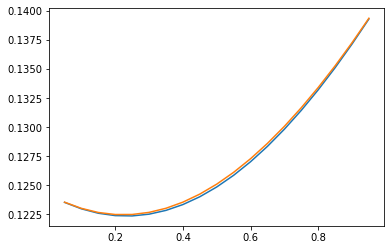

In [109]:
errors_linear_y = np.mean(errors_linear, axis=0)
errors_times_y = np.mean(errors_times, axis=0)
lasso_weights = np.arange(0.05, 1, 0.05)
plt.plot(lasso_weights, errors_times_y)
plt.plot(lasso_weights, errors_linear_y)
# Will just use linear combination
best_error = np.min(errors_times_y)
best_w = lasso_weights[errors_times_y == best_error]
print(best_w)

In [105]:
xgb = XGBRegressor(n_jobs=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.5,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000).fit(X, y_log)
lasso = Lasso(random_state=0, max_iter=50000, alpha=0.000278).fit(X, y_log)

In [110]:
# Prediction
y_pred_xgb = xgb.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
# y_pred = y_pred_lasso * best_w + y_pred_xgb * (1 - best_w)
y_pred = y_pred_lasso ** best_w * y_pred_xgb ** (1 - best_w)
y_final = np.exp(y_pred) - 1
test_data['SalePrice'] = y_final
submission = test_data[[c for c in test_data.columns if c in submit]]
submission.to_csv('./data/teamJarvis_lasso_xgb.csv', index=False)